In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import pickle
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import cv2 as cv
import os 
import sys

sys.path.append(os.path.dirname(os.path.abspath('.')))
from unet import UNet
from AttnUNet import AttU_Net
from ResUNet import Res_UNet

Custom Dataset Class

In [2]:
class LaneDataset(Dataset):
    '''Expects x and y to be np arrays
    x.shape=(num_samples,80,160,3)
    y.shape=(num_samples,80,160,1)
    converts them to pytroch (3,80,160) and (1,80,160)'''
    def __init__(self,images,labels):
        super().__init__()
        self.images = images
        self.labels=labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx],dtype=torch.float).permute(2,0,1) #change to (3,80,160)
        label = torch.tensor(self.labels[idx],dtype=torch.float).permute(2,0,1) #change to (1,80,160)
        return img,label

In [3]:
train_pickle=pickle.load(open('data/full_CNN_train.p','rb'))
train_labels=pickle.load(open('data/full_CNN_labels.p','rb'))
train_features=np.array(train_pickle)
train_labels=np.array(train_labels)/255 #normalize
# train_features,train_labels=shuffle(train_features,train_labels)
X_train, X_val, y_train, y_val=train_test_split(train_features,train_labels)
train_dataset=LaneDataset(X_train, y_train)
val_dataset=LaneDataset(X_val,y_val)
train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=128,shuffle=True)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
AttU_model = AttU_Net(3, 1).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(AttU_model.parameters(),lr=1e-4)

Model

In [12]:
UNet_model = UNet(3,1).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(UNet_model.parameters(),lr=1e-4)

In [4]:
ResUNet = Res_UNet(3,1).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ResUNet.parameters(),lr=1e-4)

In [5]:
num_epochs=2
for epoch in range(num_epochs):
    ResUNet.train()
    running_loss=0
    for batch_x,batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device),batch_y.to(device)

        optimizer.zero_grad()
        output=ResUNet(batch_x)
        loss=criterion(output,batch_y)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    print(f'Epoch {epoch+1}, loss: {running_loss/len(train_loader)}')

Epoch 1, loss: 0.1383989942073822
Epoch 2, loss: 0.018239715757469337


In [ ]:
torch.save(AttU_Net.state_dict(),'model.pth')

In [13]:
UNet_model.load_state_dict(torch.load('model_one.pth',map_location=device))

<All keys matched successfully>

Test

In [15]:
import cv2 as cv
from moviepy import VideoFileClip
import numpy as np

In [16]:

class Lanes():
    def __nit__(self):
        self.recent_fit = []
        self.avg_fit = []

def road_lines(image,model,lanes):
    small_img = cv.imresize(image,(3,80,160))
    small_img = np.array(small_img)
    small_img = small_img[None,:,:,:]

    prediction = model.eval()
    lanes.recent_fit.append(prediction)

    if len(lanes.recent_fit) >5:
        lanes.recent_fit = lanes.recent_fit[1:]
    
    lanes.avg_fit = np.mean(np.array([i for i in lanes.recent_fit]),axis=0)

    blanks = np.zeros_like(lanes.avg_fit).astype(np.uint8)
    lane_drawn = np.dstack((blanks, lanes.avg_fit, blanks))

    lane_image = cv.imresize(lane_drawn, (720,1280,3))
    result = cv.addWeighted(image,1,lane_image,1,0)

    return result
# lanes= Lanes()
# vid_input = VideoFileClip(r'.mp4')
# vid_output = 'output_test.mp4'

# vid_clip = vid_input.fl_image(road_lines)
# vid_clip.write_videofile(vid_output)

In [8]:
import matplotlib.pyplot as plt

In [6]:
ResUNet.eval()
for batch_x,batch_y in val_loader:
    batch_x, batch_y = batch_x.to(device),batch_y.to(device)
    with torch.no_grad():
        output=ResUNet(batch_x)
    break


(np.float64(-0.5), np.float64(159.5), np.float64(79.5), np.float64(-0.5))

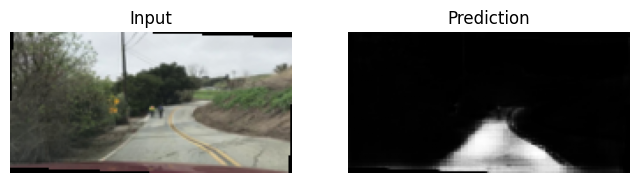

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

img = batch_x[100].detach().cpu()                 
img = img / 255.0 if img.dtype.is_floating_point else img
img = img.permute(1,2,0)  
img = img.numpy()                     

axes[0].imshow(img)
axes[0].set_title("Input")
axes[0].axis('off')

axes[1].imshow(output[100].cpu().squeeze(), cmap='gray') 
axes[1].set_title("Prediction")
axes[1].axis('off')

In [17]:
UNet_model.eval()
lanes=Lanes()
clip_input=VideoFileClip('input_clip.mp4')
vid_output='output_video.mp4'
def process_frame(frame):
    frame_bgr=cv.cvtColor(frame,cv.COLOR_RGB2BGR)
    output_bgr=road_lines(frame_bgr,UNet_model,lanes)
    return cv.cvtColor(output_bgr,cv.COLOR_BGR2RGB)
vid_clip=clip_input.fl_image(process_frame)
vid_clip.write_videofile(vid_output,audio=False)

FileNotFoundError: 'input_clip.mp4' not found